# BBBC039 Preprocessing Analysis


Analysis of the preprocessing pipeline for the BBBC039 dataset following dataset setup and partitioning. This will implement, evaluate and visualise the main steps during this pipeline and show different comparisons for reference. Preprocessing functions take input image and label filepaths to then write new image and label files in a new directory.


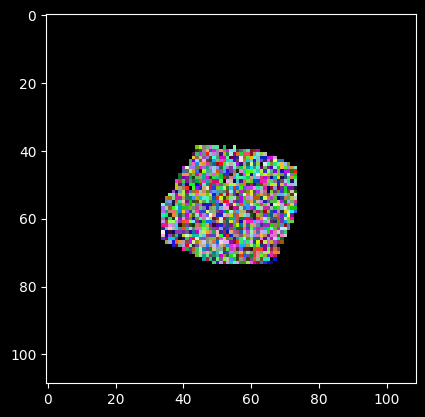

In [272]:
plt.imshow(ToPILImage()(RandAugmentSegmentation(10, 0.1)(image)))
# RandAugmentSegmentation.CentreCrop.build(0.1, image)(image).shape
# CenterCrop(size=(
#                     int(image.shape[-1] * 0.2 * 0.5),
#                     int(image.shape[-2] * 0.2 * 0.5),
#                 ))(image)
# ToPILImage()(RandAugmentSegmentation.CentreCrop.build(0.1, image)(image))
# ToPILImage()(CenterCrop(size=(
#                     int(image.shape[-1] * 0.2 * 0.5),
#                     int(image.shape[-2] * 0.2 * 0.5),
#                 ))(image))

RuntimeError: uniform_ expects to return a [from, to) range, but found from=72 > to=0

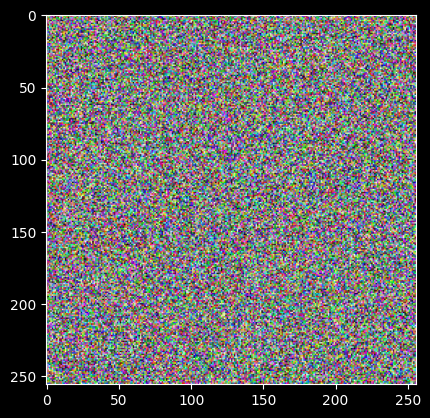

In [36]:
import torch
import matplotlib.pyplot as plt
from torchvision.transforms import *
from randaugment import RandAugmentSegmentation

image = torch.randn((3, 256, 256))
plt.imshow(ToPILImage()(image))
aug = RandAugmentSegmentation(5, 0.2)(image)
plt.imshow(ToPILImage()(aug))

In [ ]:
import warnings
from pathlib import Path
from PIL import Image

import cv2
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import numpy.typing as npt
import pandas as pd
import seaborn as sns
import skimage

from dataset import BBBC039Segmentation

In [ ]:
# Setup default plotting environment
sns.set_style("whitegrid")
sns.set_context("paper")
mpl.rcParams["legend.frameon"] = True
mpl.rcParams["axes.grid"] = True
mpl.rcParams["grid.alpha"] = 0.5
mpl.rcParams["mathtext.fontset"] = "stix"
mpl.rcParams["font.family"] = "STIXGeneral"

In [ ]:
# Load dataset and examples for preprocessing
dataset = BBBC039Segmentation("./datasets/bbbc039")
image = np.array(Image.open("./examples/image.tif"))
label = np.array(Image.open("./examples/label.png"))

## 1. Visualising Original Examples


In [ ]:
# Read in training images and labels
images = (
    [i for i in (dataset.images_dir / "train").iterdir() if i.name.endswith(".tif")]
    + [i for i in (dataset.images_dir / "val").iterdir() if i.name.endswith(".tif")]
    + [i for i in (dataset.images_dir / "test").iterdir() if i.name.endswith(".tif")]
)
labels = (
    [i for i in (dataset.labels_dir / "train").iterdir() if i.name.endswith(".png")]
    + [i for i in (dataset.labels_dir / "val").iterdir() if i.name.endswith(".png")]
    + [i for i in (dataset.labels_dir / "test").iterdir() if i.name.endswith(".png")]
)
images = np.array([np.array(Image.open(i)) for i in sorted(images)])
labels = np.array([np.array(Image.open(i)) for i in sorted(labels)])

In [ ]:
# Visualise the images with the labels
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(15, 6))
for c in range(5):
    axes[0, c].imshow(images[c])
    axes[1, c].imshow(labels[c][:, :, 0], cmap="Purples")
    axes[0, c].grid(None), axes[0, c].set_xticks([]), axes[0, c].set_yticks([])
    axes[1, c].grid(None), axes[1, c].set_xticks([]), axes[1, c].set_yticks([])
axes[0, 0].set_ylabel("Image", size=24)
axes[1, 0].set_ylabel("Ground Truth", size=24)
plt.tight_layout()
plt.show()

## 2. Visualising Optimal Image Partition


In [ ]:
# Image splitting is chosen to increase the number of training samples
pixel_split = 232
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(15, 4.5))
for c in range(5):
    axes[0, c].imshow(images[c])
    axes[1, c].imshow(labels[c][:, :, 0], cmap="Purples")
    axes[0, c].grid(None), axes[0, c].set_xticks([]), axes[0, c].set_yticks([])
    axes[1, c].grid(None), axes[1, c].set_xticks([]), axes[1, c].set_yticks([])
    axes[0, c].vlines([pixel_split * 1, pixel_split * 2], ymin=0, ymax=520, color="r")
    axes[0, c].hlines([pixel_split * 1, pixel_split * 2], xmin=0, xmax=696, color="r")
    axes[1, c].vlines([pixel_split * 1, pixel_split * 2], ymin=0, ymax=520, color="r")
    axes[1, c].hlines([pixel_split * 1, pixel_split * 2], xmin=0, xmax=696, color="r")
axes[0, 0].set_ylabel("Image", size=22)
axes[1, 0].set_ylabel("Ground Truth", size=22)
plt.tight_layout()
plt.show()

In [ ]:
def split_array(array: npt.NDArray, row: int = 2, col: int = 3, pix: int = 232) -> list:
    # Splice the array for the valid number of pixels to split
    array = array[: pix * row, : pix * col]
    # Perform vertical and horizontal splits
    split_blocks = []
    for rblock in np.hsplit(array, col):
        for cblock in np.vsplit(rblock, row):
            split_blocks.append(cblock)
    return split_blocks


# image_split = split_array(image, 2, 3, 232)[0]
# label_split = split_array(label, 2, 3, 232)[0]
image_split = image
label_split = label

In [ ]:
# Visualise a singular split
fig, axes = plt.subplots(ncols=2, figsize=(6, 12))
axes[0].imshow(image_split)
axes[1].imshow(label_split[:, :, 0], cmap="Purples")
for ax in axes:
    ax.grid(None), ax.set_xticks([]), ax.set_yticks([])
axes[0].set_xlabel("Image", size=18)
axes[1].set_xlabel("Ground Truth", size=18)
plt.tight_layout()

## 3. Convert Label Channels


In [ ]:
min_size = 50
dilations = 0
label = label_split[:, :, 0]
label_marked = skimage.morphology.label(label)
label_thresh = skimage.morphology.remove_small_objects(label_marked, min_size=min_size)
label_bounds = skimage.segmentation.find_boundaries(label_thresh)
for _ in range(dilations):
    label_bounds = skimage.morphology.binary_dilation(label_bounds)
label = np.zeros((label.shape + (3,)))
nucleus_cls, background_cls, boundary_cls = 0, 1, 2
label[(label_thresh != 0) & (label_bounds == 0), nucleus_cls] = 1
label[(label_thresh == 0) & (label_bounds == 0), background_cls] = 1
label[label_bounds == 1, boundary_cls] = 1

# Plot the preprocessing stages for convert channels
_, (ax1, ax2, ax3, ax4) = plt.subplots(ncols=4, figsize=(15, 3))
ax1.imshow(label_marked, aspect="auto", cmap="Purples")
ax2.imshow(label_thresh, aspect="auto", cmap="Purples")
ax3.imshow(label_bounds, aspect="auto", cmap="Purples")
ax4.imshow(label, aspect="auto", cmap="Purples")
for ax in (ax1, ax2, ax3, ax4):
    ax.grid(None), ax.set_xticks([]), ax.set_yticks([])
ax1.set_xlabel("Marked Nuclei", size=21)
ax2.set_xlabel("Threshold Micronuclei", size=21)
ax3.set_xlabel("Nuclei Boundaries", size=21)
ax4.set_xlabel("Augmented Channels", size=21)
plt.tight_layout()
plt.show()

## 4. Extract Bounding Box and Convex Hull


In [ ]:
# Bounding boxes and hulls for all objects
nuclei_label = label_thresh.copy().astype(np.uint8)
_box = label_thresh.copy().astype(np.uint8)
_con = [
    label_thresh.copy().astype(np.uint8),
    label_thresh.copy().astype(np.uint8),
    label_thresh.copy().astype(np.uint8),
]
_cnts = [[], [], []]
nuclei_count = label_thresh.max()
for i in range(nuclei_count + 1):
    nuclei_mask = ((label_thresh == i) * 1).astype(np.uint8)
    cntr, _ = cv2.findContours(nuclei_mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    x, y, w, h = cv2.boundingRect(cntr[0])
    epsilon = 0.01 * cv2.arcLength(cntr[0], True)
    con95 = cv2.approxPolyDP(cntr[0], 1.0, True)
    con90 = cv2.approxPolyDP(cntr[0], 0.75, True)
    con85 = cv2.approxPolyDP(cntr[0], 0.5, True)
    _con[0] = cv2.drawContours(_con[0], [con95], -1, (50, 50, 50), 2)
    _con[1] = cv2.drawContours(_con[1], [con90], -1, (50, 50, 50), 2)
    _con[2] = cv2.drawContours(_con[2], [con85], -1, (50, 50, 50), 2)
    _box = cv2.rectangle(_box, (x, y), (x + w, y + h), (50, 50, 50), 1)
    _cnts[0].append(len(con95))
    _cnts[1].append(len(con90))
    _cnts[2].append(len(con85))

# Plot the resulting changes
_, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(ncols=5, figsize=(18, 3))
ax1.imshow(nuclei_label, aspect="auto", cmap="Purples")
ax2.imshow(_box, aspect="auto", cmap="Purples")
ax3.imshow(_con[0], aspect="auto", cmap="Purples")
ax4.imshow(_con[1], aspect="auto", cmap="Purples")
ax5.imshow(_con[2], aspect="auto", cmap="Purples")
for ax in (ax1, ax2, ax3, ax4, ax5):
    ax.grid(None), ax.set_xticks([]), ax.set_yticks([])
ax1.set_xlabel("Nuclei Labels", size=18)
ax2.set_xlabel("Bounding Box", size=18)
ax3.set_xlabel(f"Convex ($\\epsilon=1.0$, $\\mu=${int(np.mean(_cnts[0]))})", size=22)
ax4.set_xlabel(f"Convex ($\\epsilon=0.75$, $\\mu=${int(np.mean(_cnts[1]))})", size=22)
ax5.set_xlabel(f"Convex ($\\epsilon=0.5$, $\\mu=${int(np.mean(_cnts[2]))})", size=22)
plt.tight_layout()
plt.show()

## 5. Merged Preprocess Pipeline


In [ ]:
split_r: int = 2
split_c: int = 3
split_p: int = 232
min_size = 50
dilations = 0
nucleus_cls, background_cls, boundary_cls = 0, 1, 2
eps = 0.75


def _preprocess(image_path: Path, label_path: Path):
    def split(array: npt.NDArray, rows: int, cols: int, pixels: int) -> list:
        blocks = []
        for rblock in np.hsplit(array[: pixels * rows, : pixels * cols], cols):
            for cblock in np.vsplit(rblock, rows):
                blocks.append(cblock)
        return blocks

    image = np.array(Image.open(image_path))
    label = np.array(Image.open(label_path))
    images = split(image, split_r, split_c, split_p)
    labels = split(label, split_r, split_c, split_p)
    images_out = images
    labels_out = []
    for idx, image in enumerate(images):
        Image.fromarray(image).save(f"{idx}.tif")
    for idx, label in enumerate(labels):
        # Construct 3-channel output class
        label_ = skimage.morphology.label(label[:, :, 0])
        label_ = skimage.morphology.remove_small_objects(label_, min_size=min_size)
        label_bounds = skimage.segmentation.find_boundaries(label_thresh)
        for _ in range(dilations):
            label_bounds = skimage.morphology.binary_dilation(label_bounds)
        label = np.zeros((label_.shape + (3,)))
        label[(label_ != 0) & (label_bounds == 0), nucleus_cls] = 1
        label[(label_ == 0) & (label_bounds == 0), background_cls] = 1
        label[label_bounds == 1, boundary_cls] = 1
        # Extract the bounding box and convex hull
        boxes, hulls = [], []
        num_objects = label_.max()
        for i in range(1, num_objects + 1):
            mask = ((label_ == i) * 1).astype(np.uint8)
            cntr, _ = cv2.findContours(mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
            if len(cntr) == 0:
                continue
            x, y, w, h = cv2.boundingRect(cntr[0])
            boxes.append(((x, y), (x + w, y), (x + w, y + h), (x, y + h)))
            hulls.append([tuple(i[0]) for i in cv2.approxPolyDP(cntr[0], eps, True)])
        labels_out.append((label, boxes, hulls))
        # Write label files
        with open(label_path.with_suffix(f".{idx}.detection.txt"), "w") as f:
            for box in boxes:
                f.write(f"{nucleus_cls} ")
                for x, y in box:
                    f.write(f" {x / 232} {y / 232}")
                f.write("\n")
        with open(label_path.with_suffix(f".{idx}.segmentation.txt"), "w") as f:
            for hull in hulls:
                f.write(f"{nucleus_cls} ")
                for x, y in hull:
                    f.write(f" {x / 232} {y / 232}")
                f.write("\n")
        Image.fromarray(label).save(label_path.with_suffix(f"{idx}.png"))